# Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import re
import warnings
import pdfplumber
import plotly.graph_objects as go
import plotly.express as px
from dataclasses import dataclass, field
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)

# Utils

In [2]:
# Fonction pour obtenir les informations des colonnes
def column_info(tables):
    pattern = r"(?<!\d)\d{2}-\d{1,5}\b"
    for index, list_info in enumerate(tables):
        matches_list = []
        for element in list_info:
            if element:
                matches = re.findall(pattern, element)
                if len(matches):
                    matches_list.append(element)
        if not len(matches_list):
            return index

# Fonction pour générer les noms de colonnes
def column_names_generate(tables, index_col_table):
    col_name_list = []
    zip_list = [list(element) for element in zip(*tables[0:index_col_table])]
    for index, col in enumerate(zip_list): # col 0 is
        # Repeat the subcolumn names
        if not col[0]:
            for index_e, e in enumerate(col):
                following_values = all(pd.Series(col[index_e:]).isna()) 
                if (not e) and (not following_values):
                    zip_list[index][index_e] = zip_list[index-1][index_e]
        cleaned_list = ['' if not x else x.replace("\n", " ") for x in col]
        col_name_list.append(" ".join(cleaned_list))
    col_name_list = [col_name.lstrip().rstrip() if col_name else col_name for col_name in col_name_list]
    return col_name_list

def correct_bold_text(df):
    rows_to_correct = []
    col_to_check = df.iloc[:, 2]  # contrôle arbitraire sur la première colonne de chiffres
    for index, val in col_to_check.items():
        if ",,," in val:
            rows_to_correct.append(index)
    if not len(rows_to_correct):
        return df
    for row in rows_to_correct:
        df.iloc[row, 2:-1] = df.iloc[row, 2:-1].str.replace(" ", "")
        correct_text = []
        for text in df.iloc[row, 2:-1]:
            text_f = ""
            for carac in range(0, len(text), 3):
                text_f += text[carac]
            correct_text.append(text_f)
        df.iloc[row, 2:-1] = correct_text
    return df
    
def flag_depense_recette(df, current_ope):
    df_copy = df.copy()
    depense_row = df_copy[df_copy.iloc[:,0]=="DEPENSES"]
    recette_row = df_copy[df_copy.iloc[:,0]=="RECETTES"]
    title_col = "type_opération"
    depense_txt = "Dépense"
    recette_txt = "Recette"
    if len(depense_row) and not len(recette_row):
        df_copy[title_col] = depense_txt
        current_ope = depense_txt
        df_copy.drop(index=depense_row.index[0], inplace=True)
    elif len(depense_row) and len(recette_row):
        df_copy[title_col] = np.where(
            (df_copy.index > depense_row.index[0]) & (df_copy.index < recette_row.index[0]),
            depense_txt,
            recette_txt
        )
        current_ope = recette_txt
        df_copy.drop(index=[depense_row.index[0], recette_row.index[0]], inplace=True)
    elif not len(depense_row) and len(recette_row):
        df_copy[title_col] = np.where(
            df_copy.index < recette_row.index[0],
            depense_txt,
            recette_txt
        )
        current_ope = recette_txt
        df_copy.drop(index=recette_row.index[0], inplace=True)
    else:
        df_copy[title_col] = current_ope
    return df_copy, current_ope
            
# Paramètres pour l'extraction avec pdfplumber
params = {
    "vertical_strategy": "explicit",
    "horizontal_strategy": "explicit",
    "explicit_vertical_lines": [],
    "explicit_horizontal_lines": [],
    "snap_tolerance": 100,
    "snap_x_tolerance": 3,
    "snap_y_tolerance": 3,
    "join_tolerance": 3,
    "join_x_tolerance": 2000,
    "join_y_tolerance": 0,
    "edge_min_length": 3,
    "min_words_vertical": 3,
    "min_words_horizontal": 3,
    "intersection_tolerance": 15,
    "intersection_x_tolerance": 3,
    "intersection_y_tolerance": 3,
    "text_tolerance": 1,
    "text_x_tolerance": 3,
    "text_y_tolerance": 3,
}

section_dict = {
    "Invest": "Section d'investissement",
    "Fonct": "Section de fonctionnement"
}

# Main

## Tome 1 - Annexes hors dettes

### Main function

In [3]:
def main_tome1_annexes_depenses_recettes(folder_path, year, files_dict, min_page, max_page, section):
    
    # Defining path
    path_pdf = os.path.join(folder_path, files_dict[year])

    # Opening PDF
    with pdfplumber.open(path_pdf) as pdf:
        # Initialisation current opération
        current_ope = "Dépense"
    
        # Initialisation final df
        final_df = dict()

        # Initialisation fonction (nom du tableau)
        fonction_tableau = "non_applicable"
        
        # Parcourir chaque page
        for page_num in range(min_page, max_page):
            if page_num in (min_page, max_page-1) or page_num%5 == 0:
                print(page_num)
                
            # Lire le tableau
            page = pdf.pages[page_num]
            params["explicit_vertical_lines"] = page.curves + page.edges
            params["explicit_horizontal_lines"] = page.curves + page.edges
            tables = page.extract_table(table_settings=params)
            text = page.extract_text()
            if tables: #Des pages peuvent être vides

                if len(text):
                    fonction_match = re.findall(r'(FONCTION .*?\n)',text)
                    if len(fonction_match):
                        fonction_tableau = fonction_match[0].replace("\n","").replace("(cid:150)","–").replace("Ø","é")
                        
                if not all(pd.Series(tables[0])==''):
                    if tables[0][0] in ("RECETTES","DEPENSES"):
                        tables.pop(0)
            
                    # Obtenir l'index des tables où les colonnes commencent
                    col_index = column_info(tables)
            
                    # Générer les noms des colonnes
                    col_names = column_names_generate(tables, col_index)
            
                    # Générer le DataFrame
                    df = pd.DataFrame(tables[col_index:], columns=col_names)
            
                    # Flag depense recette
                    df, current_ope = flag_depense_recette(df, current_ope)

                    # Corrections des éventuelles lignes en gras
                    df = correct_bold_text(df)
        
                    if not all(df.iloc[:,1].isna()):
                        # Conversion format numérique
                        for col_index in range(2, df.shape[1]-1):
                            df.iloc[:,col_index] = df.iloc[:,col_index].str.replace(" ","").str.replace(",",".").str.replace("\n","").astype(float)
                            
                        # Ajout de colonnes d'information
                        df.insert(0, "Numéro_page", page_num + 1)
                        df.insert(0, "Fonction", fonction_tableau)
                        df.insert(0, "Section", section_dict[section])
                        df.insert(0, "Fichier_source", files_dict[year])
                        df.insert(0, "Année", year)

                        # Nettoyer caractères spéciaux
                        df.columns = df.columns\
                            .str.replace("(cid:176)","°")\
                            .str.replace("Ø","é")\
                            .str.replace("(cid:244)","ô")\
                            .str.replace("(cid:224)","à")\
                            .str.replace("(cid:226)","â")\
                            .str.replace("(cid:231)","ç")\
                            .str.replace("Ł","è")\
                            .str.replace('(cid:146)',"'")\
                            .str.replace("Œ","ê")\
                            .str.replace("ß","û")
                        df["Libellé"] = df["Libellé"]\
                            .str.replace("(cid:176)","°")\
                            .str.replace("Ø","é")\
                            .str.replace("(cid:244)","ô")\
                            .str.replace("(cid:224)","à")\
                            .str.replace("(cid:226)","â")\
                            .str.replace("(cid:231)","ç")\
                            .str.replace("Ł","è")\
                            .str.replace('(cid:146)',"'")\
                            .str.replace("Œ","ê")\
                            .str.replace("ß","û")
                        
                        # Concatenating
                        if page_num == min_page:
                            final_df[page_num] = df
                        else:
                            precedent_key = list(final_df)[-1]
                            if df.shape[1]==final_df[precedent_key].shape[1] and all(df.columns == final_df[precedent_key].columns):
                                final_df[page_num] = pd.concat([final_df[precedent_key], df]).reset_index(drop=True)
                                final_df.pop(precedent_key)
                            else:
                                final_df[page_num] = df
    return final_df

### Params

In [4]:
# Définir le chemin du fichier PDF
folder_path = os.path.join("sources", "Tome_1")

# Creation dictionnaire fichiers
files_dict = {
    2023: "CA 2023 - Budget général Compte sur chiffres et annexes Tome 1.pdf",
    2022: "02 - CA 2022 Budget général - Compte sur chiffres et annexes - Tome 1.pdf",
    2021: "CA 2021 - Tome 1.pdf",
    2020: "04 Document budgétaire (Tome 1).pdf",
    2019: "04 - Document budgétaire (Tome 1.1).pdf"
}

### Extraction

In [5]:
all_df = {}

In [6]:
year = 2023
tome1_2023_invest = main_tome1_annexes_depenses_recettes(folder_path, year, files_dict, min_page = 110, max_page = 157, section="Invest")
tome1_2023_fonct = main_tome1_annexes_depenses_recettes(folder_path, year, files_dict, min_page = 159, max_page = 247, section="Fonct")
all_df[f"Tome 1_{year}_Section_Investissement"] = tome1_2023_invest
all_df[f"Tome 1_{year}_Section_Fonctionnement"] = tome1_2023_fonct

110
115
120
125
130
135
140
145
150
155
156
159
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
246


In [7]:
year = 2022
tome1_2022_invest = main_tome1_annexes_depenses_recettes(folder_path, year, files_dict, min_page = 110, max_page = 155, section="Invest")
tome1_2022_fonct = main_tome1_annexes_depenses_recettes(folder_path, year, files_dict, min_page = 159, max_page = 244, section="Fonct")
all_df[f"Tome 1_{year}_Section_Investissement"] = tome1_2022_invest
all_df[f"Tome 1_{year}_Section_Fonctionnement"] = tome1_2022_fonct

110
115
120
125
130
135
140
145
150
154
159
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
243


In [8]:
year = 2021
tome1_2021_invest = main_tome1_annexes_depenses_recettes(folder_path, year, files_dict, min_page = 110, max_page = 149, section="Invest")
tome1_2021_fonct = main_tome1_annexes_depenses_recettes(folder_path, year, files_dict, min_page = 154, max_page = 238, section="Fonct")
all_df[f"Tome 1_{year}_Section_Investissement"] = tome1_2021_invest
all_df[f"Tome 1_{year}_Section_Fonctionnement"] = tome1_2021_fonct

110
115
120
125
130
135
140
145
148
154
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
237


In [9]:
year = 2020
tome1_2020_invest = main_tome1_annexes_depenses_recettes(folder_path, year, files_dict, min_page = 112, max_page = 152, section="Invest")
tome1_2020_fonct = main_tome1_annexes_depenses_recettes(folder_path, year, files_dict, min_page = 156, max_page = 239, section="Fonct")
all_df[f"Tome 1_{year}_Section_Investissement"] = tome1_2020_invest
all_df[f"Tome 1_{year}_Section_Fonctionnement"] = tome1_2020_fonct

112
115
120
125
130
135
140
145
150
151
156
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
238


In [10]:
year = 2019
tome1_2019_invest = main_tome1_annexes_depenses_recettes(folder_path, year, files_dict, min_page = 113, max_page = 161, section="Invest")
tome1_2019_fonct = main_tome1_annexes_depenses_recettes(folder_path, year, files_dict, min_page = 165, max_page = 262, section="Fonct")
all_df[f"Tome 1_{year}_Section_Investissement"] = tome1_2019_invest
all_df[f"Tome 1_{year}_Section_Fonctionnement"] = tome1_2019_fonct

113
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
261


In [11]:
all_df.keys()

dict_keys(['Tome 1_2023_Section_Investissement', 'Tome 1_2023_Section_Fonctionnement', 'Tome 1_2022_Section_Investissement', 'Tome 1_2022_Section_Fonctionnement', 'Tome 1_2021_Section_Investissement', 'Tome 1_2021_Section_Fonctionnement', 'Tome 1_2020_Section_Investissement', 'Tome 1_2020_Section_Fonctionnement', 'Tome 1_2019_Section_Investissement', 'Tome 1_2019_Section_Fonctionnement'])

### Stacking

In [12]:
df_all_stack = pd.DataFrame()
for file_name, dict_year in all_df.items():
    for _, df in dict_year.items():
        df_stack = pd.DataFrame(
            df.set_index(["Année","Fichier_source","Fonction","Section","Libellé","type_opération","Article / compte nature (1)","Numéro_page"]
                          )\
            .stack()
        )\
        .reset_index()\
        .rename(
            columns={
                "level_8":"Nom_Colonne", 
                0:"Valeur"
            }
        )
        df_all_stack = pd.concat([df_all_stack, df_stack])
df_all_stack.reset_index(drop=True, inplace=True)
df_all_stack.head()

,Année,Fichier_source,Fonction,Section,Libellé,type_opération,Article / compte nature (1),Numéro_page,Nom_Colonne,Valeur
0,2023,CA 2023 - Budget général Compte sur chiffres e...,FONCTION 0 – Services généraux,Section d'investissement,"Subv. non transf. Etat, établ. nationaux",Dépense,1321,111,90-02 Administration générale 90-020 Admin. gé...,0.00
1,2023,CA 2023 - Budget général Compte sur chiffres e...,FONCTION 0 – Services généraux,Section d'investissement,"Subv. non transf. Etat, établ. nationaux",Dépense,1321,111,90-02 Administration générale 90-021 Personnel...,0.00
2,2023,CA 2023 - Budget général Compte sur chiffres e...,FONCTION 0 – Services généraux,Section d'investissement,"Subv. non transf. Etat, établ. nationaux",Dépense,1321,111,90-02 Administration générale 90-022 Informati...,0.00
3,2023,CA 2023 - Budget général Compte sur chiffres e...,FONCTION 0 – Services généraux,Section d'investissement,"Subv. non transf. Etat, établ. nationaux",Dépense,1321,111,90-02 Administration générale 90-023 Fêtes et ...,0.00
4,2023,CA 2023 - Budget général Compte sur chiffres e...,FONCTION 0 – Services généraux,Section d'investissement,"Subv. non transf. Etat, établ. nationaux",Dépense,1321,111,90-02 Administration générale 90-024 Aide aux ...,0.00


### Excel extraction

In [13]:
# # Use ExcelWriter to write each DataFrame to a sheet
# for file_name, dict_year in all_df.items():
#     file_name = f"{file_name}.xlsx"
#     with pd.ExcelWriter(file_name, engine='xlsxwriter') as writer:
#         for sheet_name, df in dict_year.items():
#             sheet_name = str(sheet_name)
#             df.to_excel(writer, sheet_name=sheet_name, index=False)

In [14]:
# with pd.ExcelWriter("Tome 1_2019-2023.xlsx", engine='xlsxwriter') as writer:
#     sheet_name = "Data"
#     df_all_stack.to_excel(writer, sheet_name=sheet_name, index=False)

# Analysis

## Functions

### Class

In [153]:
@dataclass
class DepenseRecetteParis:
    df: pd.DataFrame = field(init=False)        

    def __init__(self, df: pd.DataFrame):
        
        self.df = df.query("Nom_Colonne != 'TOTAL DU CHAPITRE'")

        assert round(
            self.df[
            (self.df["Section"]=="Section de fonctionnement") & 
            (self.df["Année"]==2023) & (self.df["type_opération"]=="Dépense") & 
            (self.df["Fonction"].str.startswith("FONCTION 0 "))
        ]["Valeur"].sum()
            , 2) == 847844225.66
        
    def total_depenses_recettes(self, section: str):
        df_section = self.df[self.df["Section"] == section]
        sum_df = df_section.groupby(["Année","type_opération"], as_index=False)["Valeur"].sum()
        return sum_df

    def clean_fonction(self):
        clean_fonction_text = self.df["Fonction"].apply(lambda x: x.split("(suite")[0].rstrip().lstrip())
        clean_df = self.df.copy()
        clean_df["Fonction_clean"] = clean_fonction_text
        return clean_df
        
    def details_depenses_recettes(self, type_operation: str, section: str):
        clean_fonction_df = self.clean_fonction()
        df_section = clean_fonction_df[
            (clean_fonction_df["type_opération"] == type_operation) &
            (clean_fonction_df["Section"] == section)
        ]
        sum_df = df_section.groupby(["Année","Fonction_clean"], as_index=False)["Valeur"].sum()
        return sum_df

    def top_n(self, section: str, type_operation: str, annee: int, n: int):
        df_type_op = self.df[
            (self.df["Section"]==section) &
            (self.df["type_opération"]==type_operation) &
            (self.df["Année"]==annee)
        ]
        top_n_df = df_type_op.sort_values(by=["Valeur"], ascending=False)[:n]
        return top_n_df

    def depense_years_unstack(self, type_operation: str):
        df_type_op = self.df[
            (self.df["Section"]=="Section de fonctionnement") &
            (self.df["type_opération"]==type_operation)
        ]
        df_gpby_unstack = df_type_op.groupby(["Année","Nom_Colonne"])["Valeur"].sum().unstack(level=-1)
        return df_gpby_unstack

    def diff_depense_years(self, type_operation:str, relative: bool =False):
        df_gpby_unstack = self.depense_years_unstack(type_operation)
        if relative:
            df_diff = df_gpby_unstack.pct_change().stack().reset_index().rename(columns={0: "Valeur"})
            df_diff["Valeur"] = round(df_diff["Valeur"],2)

        else:
            df_diff = df_gpby_unstack.diff().stack().reset_index().rename(columns={0: "Valeur"})
            df_diff["Valeur"] = round(df_diff["Valeur"],2)
        return df_diff
        

### DataViz

In [57]:
def bar_chart(df, x, y, split, orient, title, hover=None):
    # Create a Plotly figure
    fig = go.Figure()

    if split:
        # Iterate through unique names in column B
        for name in df[split].unique():
    
            # Filter data for the current name
            filtered_df = df[df[split] == name]
          
            # Add a bar trace for this name
            fig.add_trace(go.Bar(
                x=filtered_df[x],  # Years
                y=filtered_df[y],  # Values
                name=str(name), # Name of the trace
                orientation=orient
            ))
            
        # Customize the layout
        fig.update_layout(
            title=title,
            # xaxis=dict(title=x),
            # yaxis=dict(title="€"),
            barmode='group',  # Grouped bar chart
            legend=dict(title=split)
        )
    else:
        # Add a bar trace for this name
        fig.add_trace(go.Bar(
            x=df[x],  # Years
            y=df[y],  # Values
            hovertext= df[hover], # Hover text
            orientation=orient
        ))
            
        # Customize the layout
        fig.update_layout(
            title=title,
            # xaxis=dict(title=x),
            # yaxis=dict(title="€"),
            barmode='group',  # Grouped bar chart
        )

    return fig

## Results

### Dépenses de fonctionnement

In [154]:
section_name = "Section de fonctionnement"
deprec = DepenseRecetteParis(df_all_stack)
tot_dep_rec_fonct = deprec.total_depenses_recettes(section=section_name)
details_depenses_fonct = deprec.details_depenses_recettes(type_operation="Dépense",section=section_name)
df_diff_abs = deprec.diff_depense_years(type_operation="Dépense")
df_diff_relat = deprec.diff_depense_years(type_operation="Dépense", relative=True).rename(columns={"Valeur":"Pct_change"})
df_diff = pd.merge(df_diff_abs, df_diff_relat, how='left', on=["Année","Nom_Colonne"])

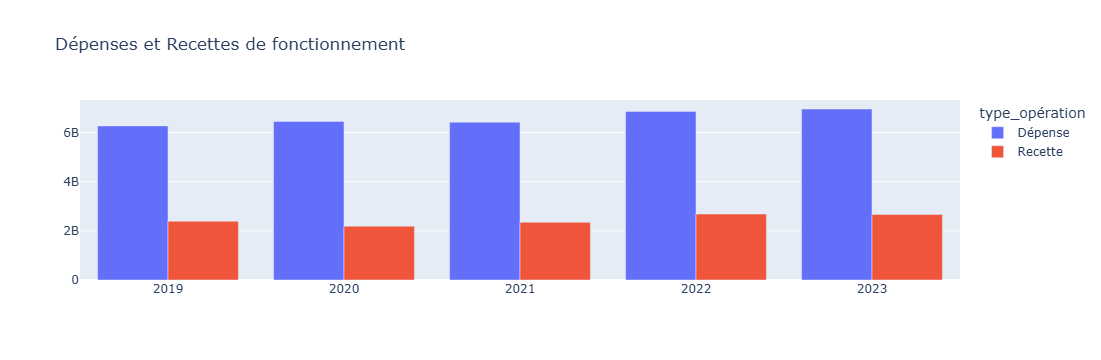

In [104]:
title = "Dépenses et Recettes de fonctionnement"
bar_chart(tot_dep_rec_fonct, x="Année",y="Valeur",split="type_opération", orient="v", title=title).show()

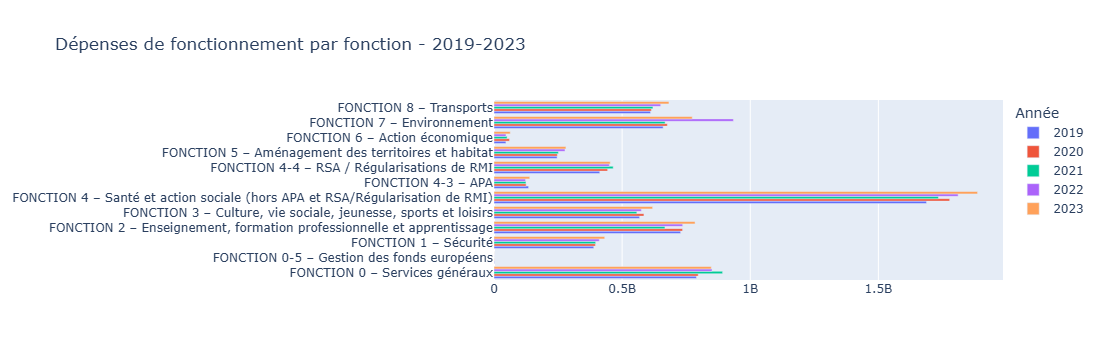

In [59]:
title = "Dépenses de fonctionnement par fonction - 2019-2023"
bar_chart(details_depenses_fonct, x="Valeur",y="Fonction_clean",split="Année", orient="h", title=title).show()

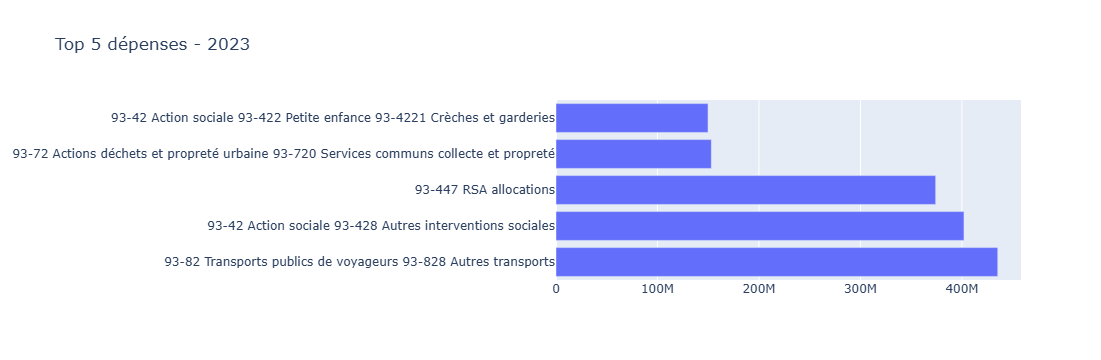

In [60]:
n = 5
year = 2023
top_depense_year_fonct = deprec.top_n(section=section_name, type_operation="Dépense", annee=year, n=n)
title = f"Top {n} dépenses - {year}"
bar_chart(top_depense_year_fonct, x="Valeur",y="Nom_Colonne",split=None, orient="h", title=title, hover="Libellé").show()

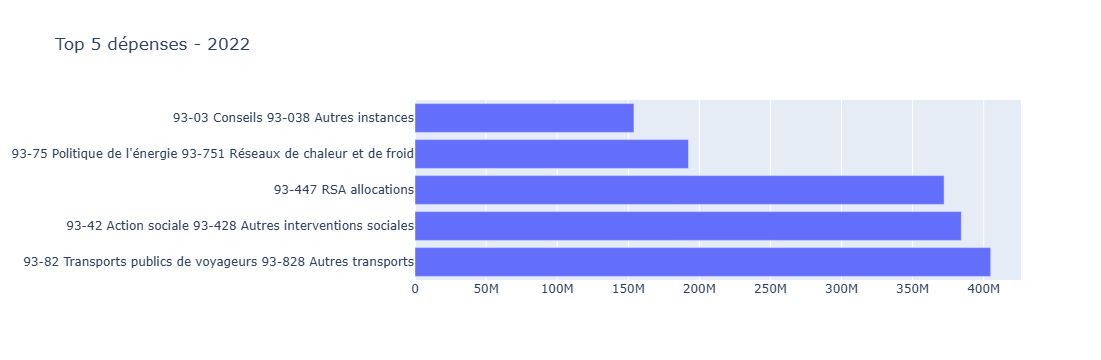

In [61]:
n = 5
year = 2022
top_depense_year_fonct = deprec.top_n(section=section_name, type_operation="Dépense", annee=year, n=n)
title = f"Top {n} dépenses - {year}"
bar_chart(top_depense_year_fonct, x="Valeur",y="Nom_Colonne",split=None, orient="h", title=title, hover="Libellé").show()

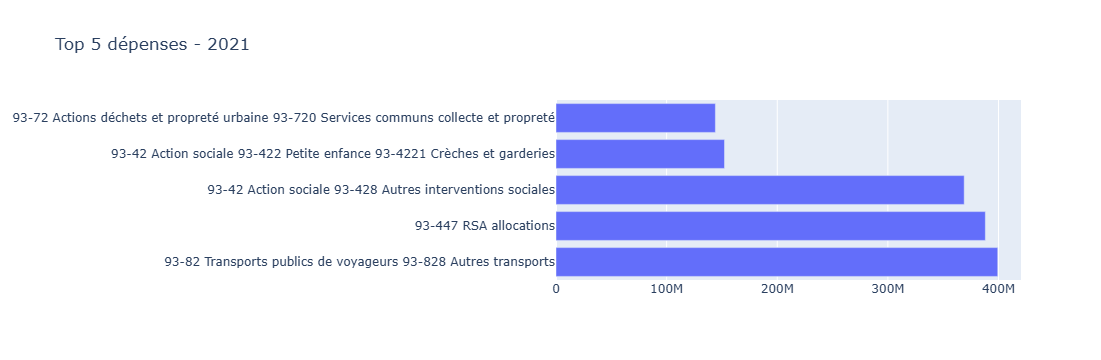

In [62]:
n = 5
year = 2021
top_depense_year_fonct = deprec.top_n(section=section_name, type_operation="Dépense", annee=year, n=n)
title = f"Top {n} dépenses - {year}"
bar_chart(top_depense_year_fonct, x="Valeur",y="Nom_Colonne",split=None, orient="h", title=title, hover="Libellé").show()

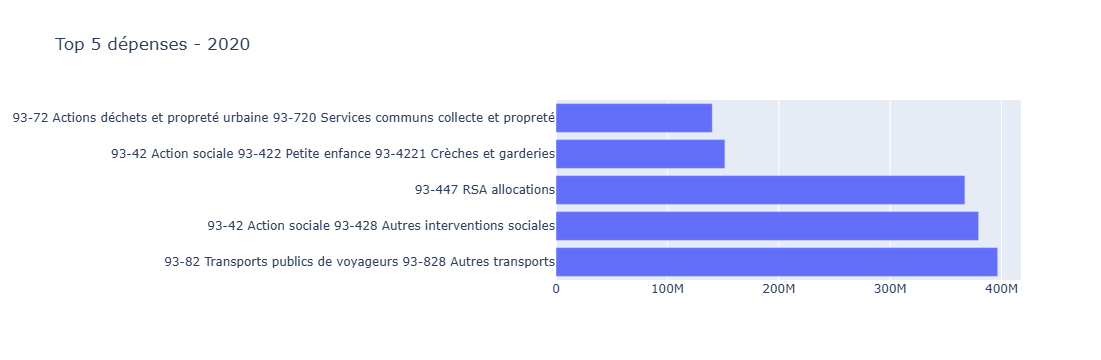

In [63]:
n = 5
year = 2020
top_depense_year_fonct = deprec.top_n(section=section_name, type_operation="Dépense", annee=year, n=n)
title = f"Top {n} dépenses - {year}"
bar_chart(top_depense_year_fonct, x="Valeur",y="Nom_Colonne",split=None, orient="h", title=title, hover="Libellé").show()

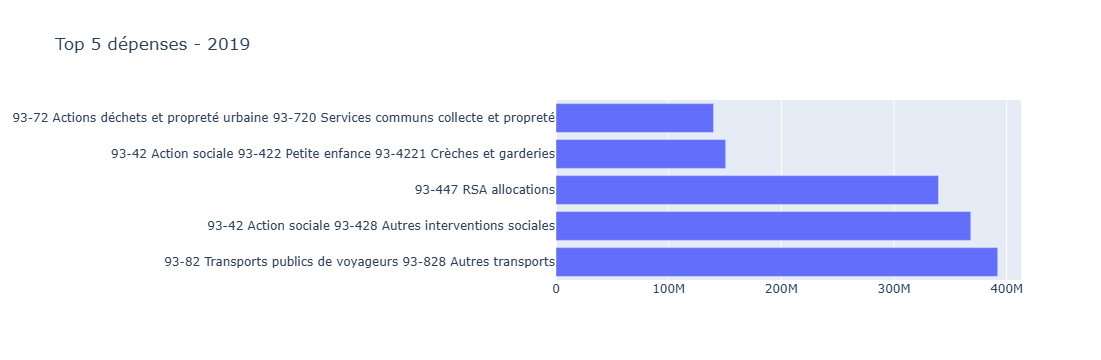

In [64]:
n = 5
year = 2019
top_depense_year_fonct = deprec.top_n(section=section_name, type_operation="Dépense", annee=year, n=n)
title = f"Top {n} dépenses - {year}"
bar_chart(top_depense_year_fonct, x="Valeur",y="Nom_Colonne",split=None, orient="h", title=title, hover="Libellé").show()

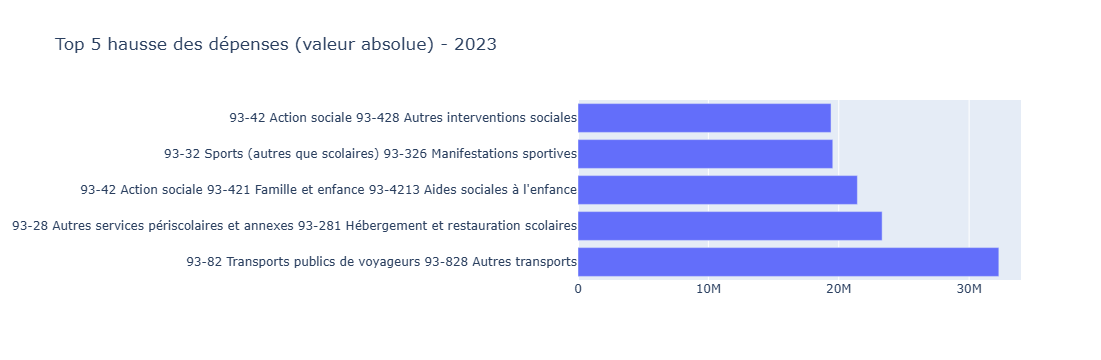

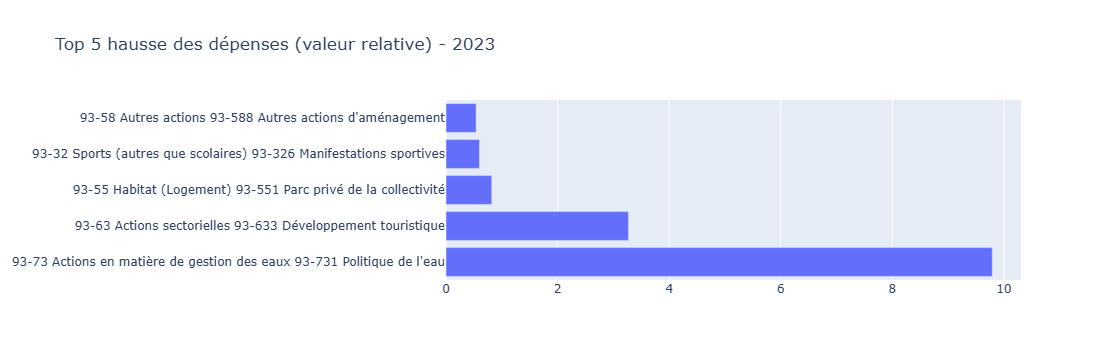

In [155]:
n = 5
year = 2023
df_diff_year = df_diff[
    (df_diff["Année"]==year) &
    (df_diff["Valeur"] > 0)
]
title = f"Top {n} hausse des dépenses (valeur absolue) - {year}"
bar_chart(df_diff_year.sort_values(by=["Valeur"], ascending=False)[:n], x="Valeur",y="Nom_Colonne",split=None, orient="h", title=title, hover="Pct_change").show()
title = f"Top {n} hausse des dépenses (valeur relative) - {year}"
bar_chart(df_diff_year.sort_values(by=["Pct_change"], ascending=False)[:n], x="Pct_change",y="Nom_Colonne",split=None, orient="h", title=title, hover="Valeur").show()

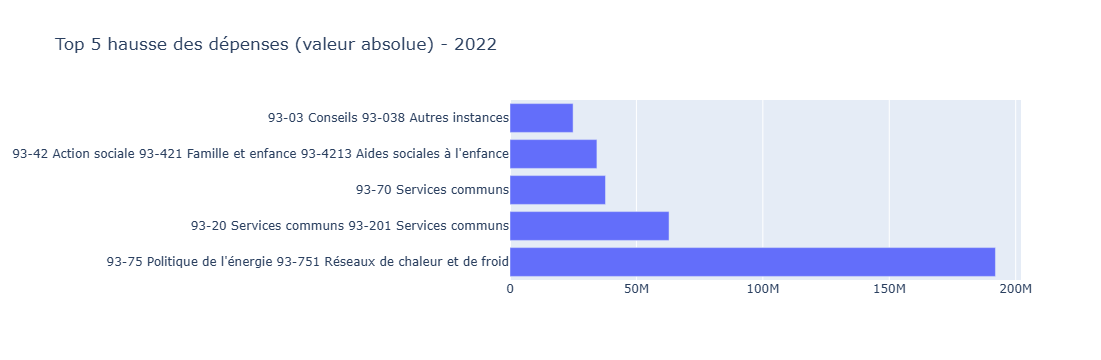

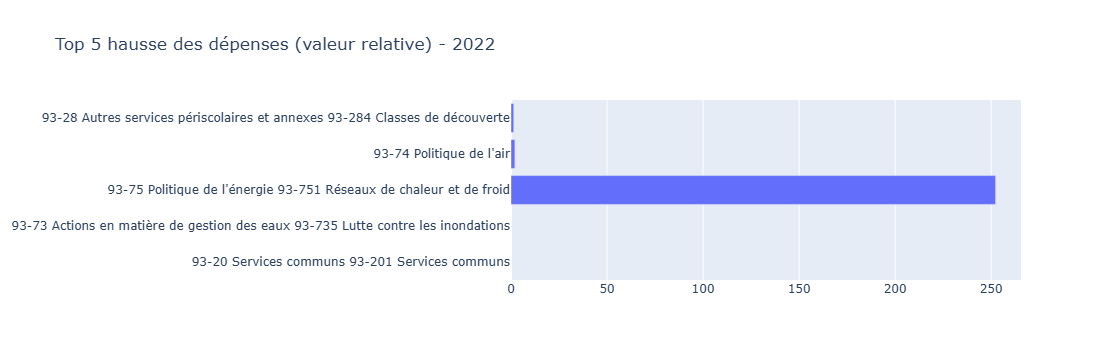

In [158]:
n = 5
year = 2022
df_diff_year = df_diff[
    (df_diff["Année"]==year) &
    (df_diff["Valeur"] > 0)
]
title = f"Top {n} hausse des dépenses (valeur absolue) - {year}"
bar_chart(df_diff_year.sort_values(by=["Valeur"], ascending=False)[:n], x="Valeur",y="Nom_Colonne",split=None, orient="h", title=title, hover="Pct_change").show()
title = f"Top {n} hausse des dépenses (valeur relative) - {year}"
bar_chart(df_diff_year.sort_values(by=["Pct_change"], ascending=False)[:n], x="Pct_change",y="Nom_Colonne",split=None, orient="h", title=title, hover="Valeur").show()

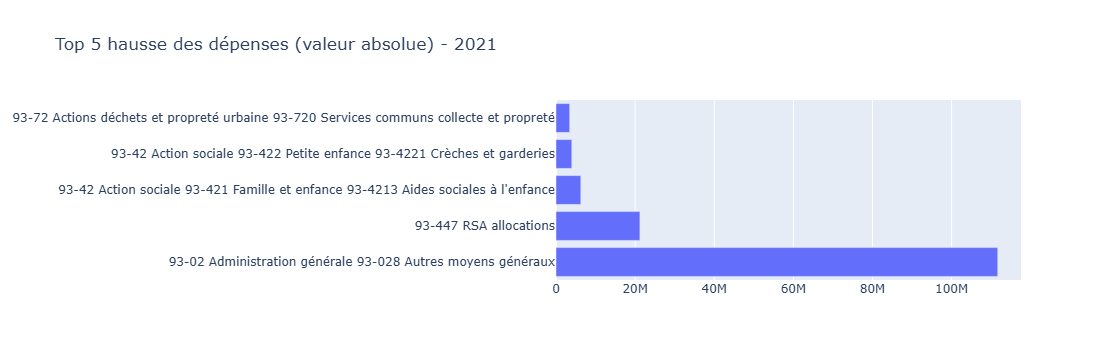

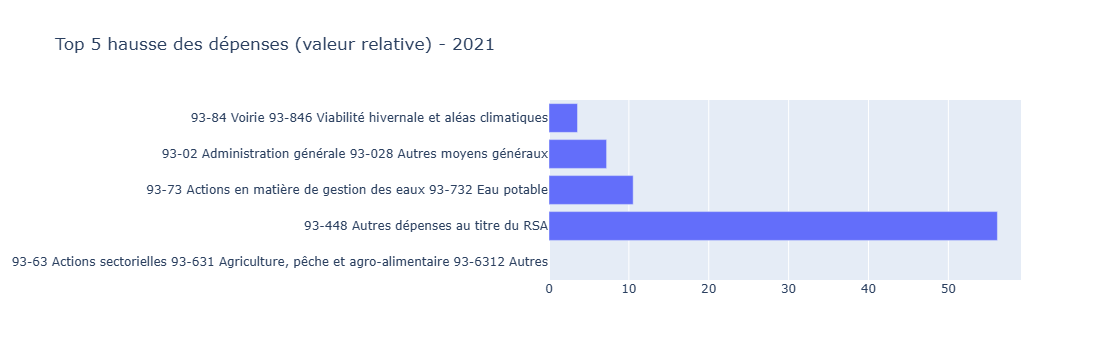

In [165]:
n = 5
year = 2021
df_diff_year = df_diff[
    (df_diff["Année"]==year) &
    (df_diff["Valeur"] > 0)
]
title = f"Top {n} hausse des dépenses (valeur absolue) - {year}"
bar_chart(df_diff_year.sort_values(by=["Valeur"], ascending=False)[:n], x="Valeur",y="Nom_Colonne",split=None, orient="h", title=title, hover="Pct_change").show()
title = f"Top {n} hausse des dépenses (valeur relative) - {year}"
bar_chart(df_diff_year.sort_values(by=["Pct_change"], ascending=False)[:n], x="Pct_change",y="Nom_Colonne",split=None, orient="h", title=title, hover="Valeur").show()

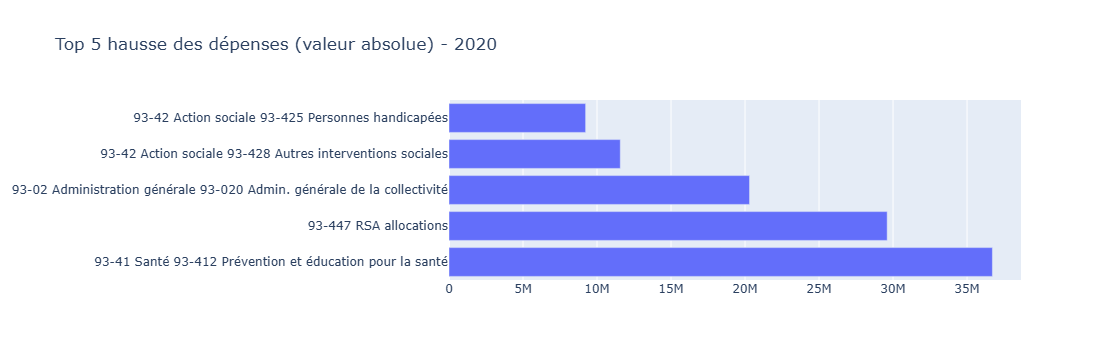

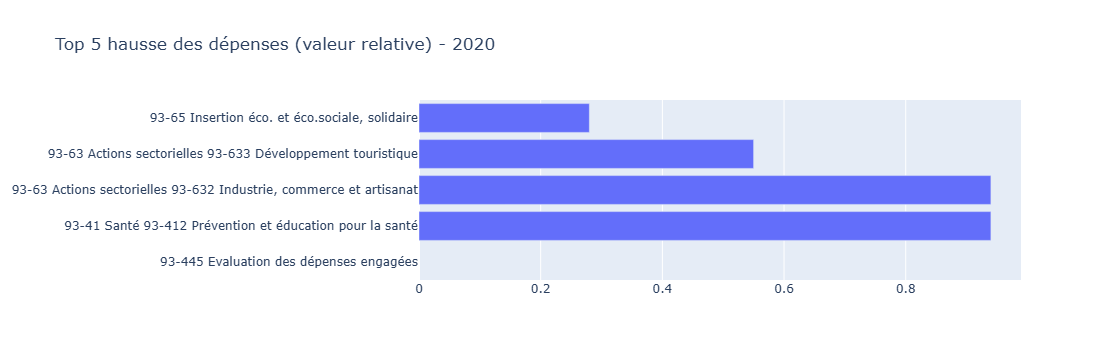

In [166]:
n = 5
year = 2020
df_diff_year = df_diff[
    (df_diff["Année"]==year) &
    (df_diff["Valeur"] > 0)
]
title = f"Top {n} hausse des dépenses (valeur absolue) - {year}"
bar_chart(df_diff_year.sort_values(by=["Valeur"], ascending=False)[:n], x="Valeur",y="Nom_Colonne",split=None, orient="h", title=title, hover="Pct_change").show()
title = f"Top {n} hausse des dépenses (valeur relative) - {year}"
bar_chart(df_diff_year.sort_values(by=["Pct_change"], ascending=False)[:n], x="Pct_change",y="Nom_Colonne",split=None, orient="h", title=title, hover="Valeur").show()